In [5]:
import requests
import json

def get_rating_data(ratings_id, host="http://localhost:9876", include_rating=False):
    response = requests.get(f"{host}/ratings?show_scores=True")
    ratings = response.json()
    rating = next(r for r in ratings if r['id'] == ratings_id)

    response = requests.get(f"{host}/testsets/{rating['testset_id']}")
    content = response.json()

    questions_json = content["questions"]
    questions = json.loads(questions_json)

    scores_json = rating['scores']
    scores = json.loads(scores_json)

    if include_rating:
        return rating, questions, scores
    
    return questions, scores

In [6]:
def merge_questions_and_scores(questions, scores):
    """
    Merge questions and scores into a single DataFrame.
    
    Args:
        questions (dict): Dictionary containing questions data
        scores (dict): Dictionary containing scores data
        
    Returns:
        pd.DataFrame: Merged DataFrame containing both questions and scores
    """
    import pandas as pd
    
    df_scores = pd.DataFrame(scores)
    reshaped_scores = df_scores.to_dict('records')

    df_questions = pd.DataFrame(questions)
    reshaped_questions = df_questions.reset_index().rename(columns={'index': 'id'}).to_dict('records')

    if not len(reshaped_questions) == len(reshaped_scores):
        raise ValueError("Number of questions and scores do not match")

    # Create a list to store merged entries
    merged_entries = []

    # Iterate through reshaped_questions and merge with corresponding scores
    for i, question in enumerate(reshaped_questions):
        if i < len(reshaped_scores):
            merged_entry = question.copy()  # Start with question entry
            merged_entry.update(reshaped_scores[i])  # Update with score data
            merged_entries.append(merged_entry)
        else:
            merged_entries.append(question)  # Add question without scores if no matching score exists

    # Convert back to DataFrame for easier manipulation if needed
    return pd.DataFrame(merged_entries)

def get_entry_by_id(df, entry_id):
    """
    Get a specific entry from the DataFrame by its ID with fields in a specific order.
    
    Args:
        df (pd.DataFrame): The merged DataFrame containing questions and scores
        entry_id (int): The ID of the entry to retrieve
        
    Returns:
        dict: The row matching the given ID with ordered fields, or None if not found
    """
    matching_row = df[df['id'] == entry_id]
    
    if matching_row.empty:
        return None

    # Convert to records and get first item
    record = matching_row.to_dict('records')[0]
    
    # Define order of fields
    ordered_fields = [
        'id',
        'question',
        'reference_answer',
        'response',
        'reference_context',
        'retrieved_contexts',
        'answer_relevancy',
        'context_precision', 
        'faithfulness',
        'context_recall'
    ]
    
    # Create ordered dictionary with specified fields first
    ordered_record = {field: record[field] for field in ordered_fields if field in record}
    
    # Add any remaining fields that weren't in the ordered list
    remaining_fields = {k: v for k, v in record.items() if k not in ordered_fields}
    ordered_record.update(remaining_fields)
    
    return ordered_record


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_score_distributions(df, filter_zero=False, figsize=(12, 10)):
    """
    Plot distributions of evaluation scores with optional zero value filtering.
    
    Args:
        df (pd.DataFrame): DataFrame containing the scores
        filter_zero (bool): If True, filter out scores that are 0.0
        figsize (tuple): Figure size as (width, height)
        
    Returns:
        matplotlib.figure.Figure: The created figure object
    """
    # The scores to plot
    scores_to_plot = ['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    
    # Plot the distribution for each score
    for i, score in enumerate(scores_to_plot):
        data = df[score]
        if filter_zero:
            data = data[data != 0.0]
            
        sns.histplot(data, ax=axes[i], kde=True, bins=20)
        axes[i].set_title(f'Distribution of {score}')
        axes[i].set_xlabel(score)
        axes[i].set_ylabel('Frequency')
        axes[i].set_xlim(0, 1)
        
        # Add count of filtered values if filtering is enabled
        if filter_zero:
            total = len(df[score])
            filtered = total - len(data)
            axes[i].text(0.05, 0.95, f'Filtered: {filtered}/{total} zeros',
                        transform=axes[i].transAxes, verticalalignment='top')
    
    plt.tight_layout()
    return fig

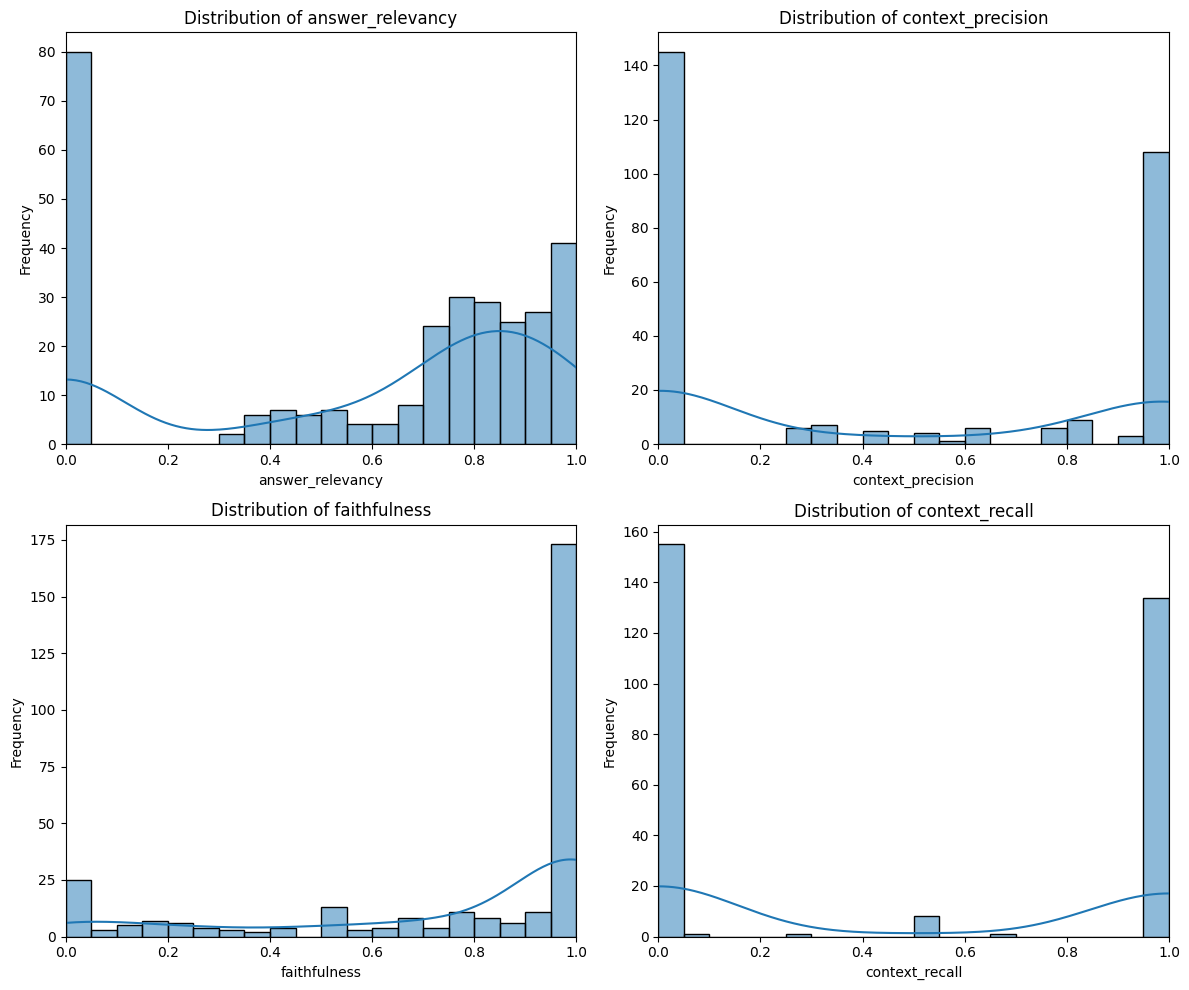

In [30]:
ratings_id = 128
rating, questions, scores = get_rating_data(ratings_id, include_rating=True)
df_merged_400_300_O_O = merge_questions_and_scores(questions, scores)

fig = plot_score_distributions(df_merged_400_300_O_O)

In [31]:
ratings_id = 128
rating, questions, scores = get_rating_data(ratings_id, include_rating=True, host="http://localhost:9876")
df_merged_400_300_O_O = merge_questions_and_scores(questions, scores)
#fig = plot_score_distributions(df_merged_400_300_O_O)

In [32]:
columns = ['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']

# Get the count of null values per column
null_counts = df_merged_400_300_O_O[columns].isnull().sum()

null_counts_df = null_counts.reset_index()
null_counts_df.columns = ['column', 'null_count']
print(null_counts_df)

null_mask = df_merged_400_300_O_O[columns].isnull()
null_entries = [(idx, col) for col in columns for idx in df_merged_400_300_O_O[null_mask[col]].index]
print(null_entries)

              column  null_count
0   answer_relevancy           0
1  context_precision           0
2       faithfulness           0
3     context_recall           0
[]


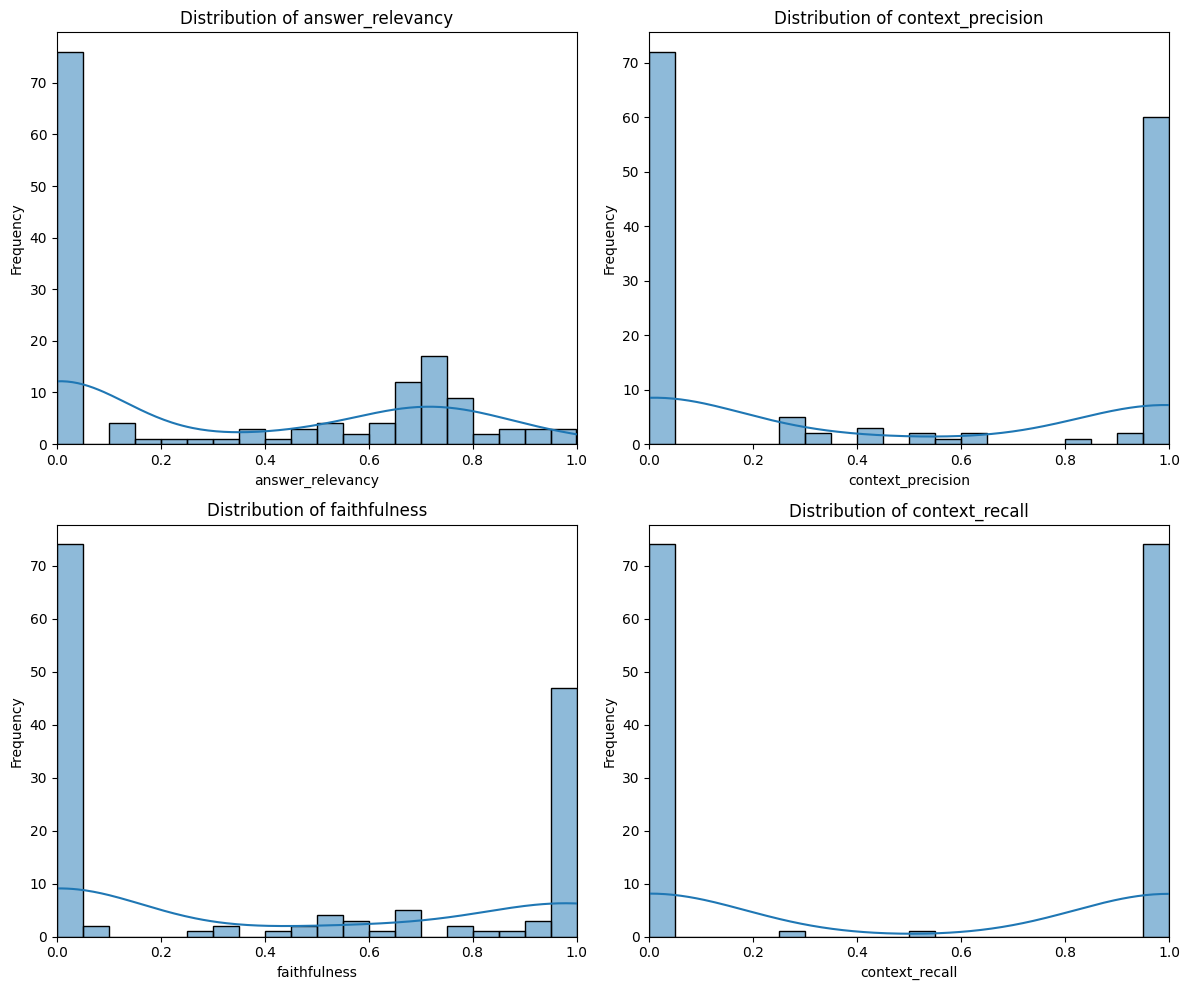

In [33]:
ratings_id = 81
rating, questions, scores = get_rating_data(ratings_id, include_rating=True)
df_merged_400_150_O_O = merge_questions_and_scores(questions, scores)

fig = plot_score_distributions(df_merged_400_150_O_O)

In [34]:
scores__400_300_O_O = df_merged_400_300_O_O[['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']]

In [35]:
print("Pearson Correlation:\n", scores__400_300_O_O.corr())
print("\nSpearman Correlation:\n", scores__400_300_O_O.corr(method='spearman'))

Pearson Correlation:
                    answer_relevancy  context_precision  faithfulness  \
answer_relevancy           1.000000           0.497853     -0.032567   
context_precision          0.497853           1.000000      0.136742   
faithfulness              -0.032567           0.136742      1.000000   
context_recall             0.437932           0.776198      0.173476   

                   context_recall  
answer_relevancy         0.437932  
context_precision        0.776198  
faithfulness             0.173476  
context_recall           1.000000  

Spearman Correlation:
                    answer_relevancy  context_precision  faithfulness  \
answer_relevancy           1.000000           0.466346     -0.076156   
context_precision          0.466346           1.000000      0.036069   
faithfulness              -0.076156           0.036069      1.000000   
context_recall             0.446615           0.762636      0.108178   

                   context_recall  
answer_relevancy

In [36]:
zero_matrix = (scores__400_300_O_O == 0).astype(int).T @ (scores__400_300_O_O == 0).astype(int)
print("Zero Co-occurrence:\n", zero_matrix)

Zero Co-occurrence:
                    answer_relevancy  context_precision  faithfulness  \
answer_relevancy                 80                 65            13   
context_precision                65                145            19   
faithfulness                     13                 19            24   
context_recall                   65                132            21   

                   context_recall  
answer_relevancy               65  
context_precision             132  
faithfulness                   21  
context_recall                155  


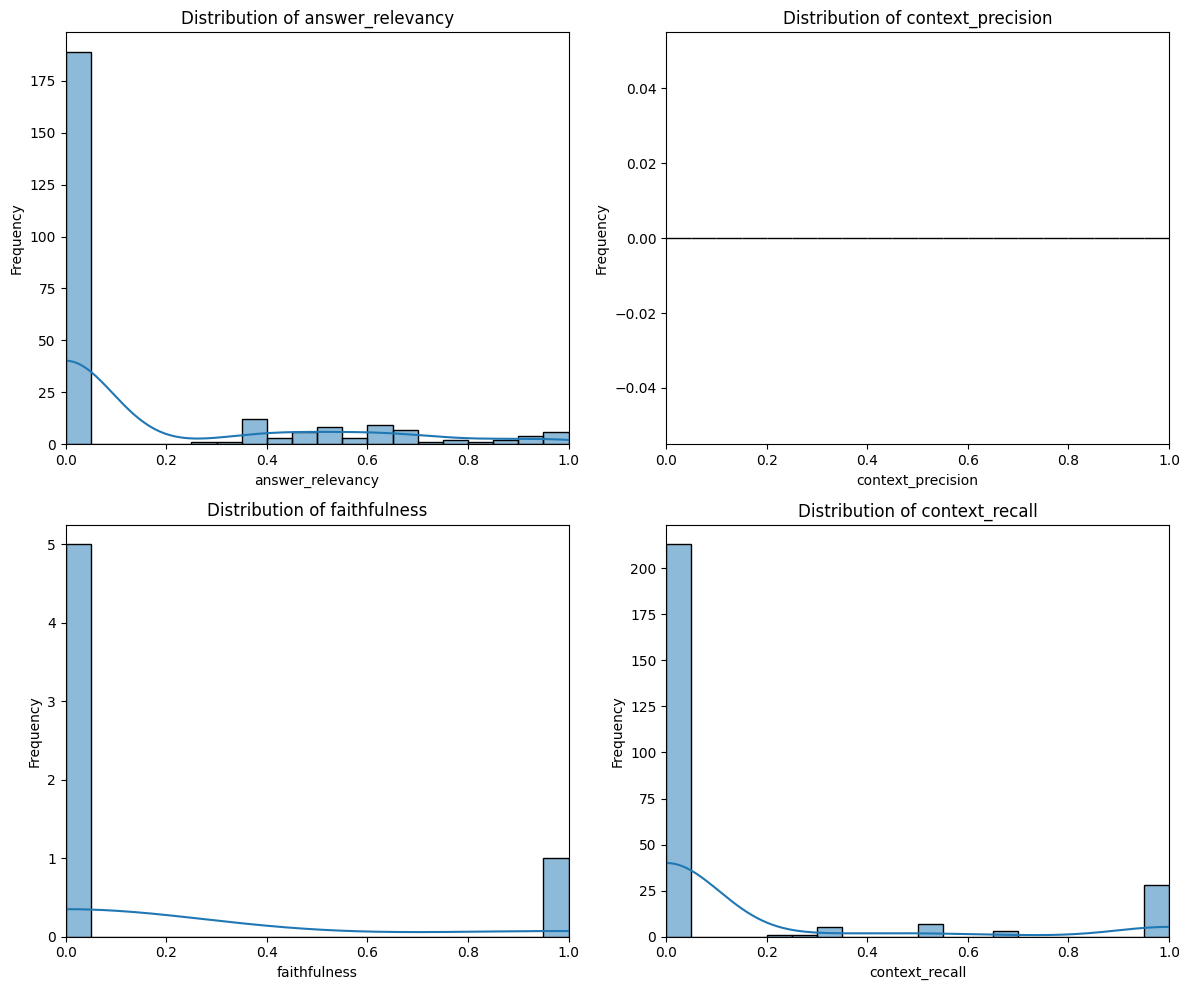

In [39]:
ratings_id = 22
rating, questions, scores = get_rating_data(ratings_id, host="http://localhost:9877", include_rating=True)
df_merged_400_300_D_D = merge_questions_and_scores(questions, scores)

fig = plot_score_distributions(df_merged_400_300_D_D)

In [40]:
df_merged_400_300_O_O[10:20].to_dict('records')

[{'id': '76732949-fb28-4fcc-9452-95ae480e8210',
  'question': "Was passiert mit dem Tag-Attribut 'style' oder 'script' mit type 'text/javascript' im gegebenen Kontext?",
  'reference_answer': "Wenn das Tag-Attribut 'style' oder 'script' mit type 'text/javascript' ist, wird das Element als forbidden markiert (h.forbidden = true), sofern die Funktion ot() nicht wahr ist.",
  'reference_context': 'Document 2519: p=r&&r.ns||Ui(t);K&&"svg"===p&&(i=function(t){for(var e=[],n=0;n<t.length;n++){var r=t[n];fa.test(r.name)||(r.name=r.name.replace(pa,""),e.push(r))}return e}(i));var d,h=oa(t,i,r);p&&(h.ns=p),"style"!==(d=h).tag&&("script"!==d.tag||d.attrsMap.type&&"text/javascript"!==d.attrsMap.type)||ot()||(h.forbidden=!0);for(var M=0;M<Xi.length;M++)h=Xi[M](h,e)||h;c||(function(t){null!=Rr(t,"v-pre")&&(t.pre=!0)}(h),h.pre&&(c=!0)),Pi(h.tag)&&(s=!0),c?function(t){var e=t.attrsList,n=e.length;if(n)for(var',
  'conversation_history': [],
  'metadata': {'question_type': 'simple',
   'seed_document_

In [41]:
df_merged_400_300_D_D.index[df_merged_400_300_D_D['id'] == 'ca83c38c-be8a-468c-97e3-c3f1da80ccdc']

Index([254], dtype='int64')

# IMPORTANT
Correlation between scores

In [42]:
import numpy as np
import pandas as pd

def conditional_zero_prob(df):
    results = {}
    for col1 in df.columns:
        results[col1] = {}
        zero_mask = df[col1] == 0
        for col2 in df.columns:
            if col1 == col2:
                continue
            prob = np.mean((df[col2] == 0)[zero_mask]) if zero_mask.any() else np.nan
            results[col1][col2] = round(prob, 3)
    return pd.DataFrame(results)

import numpy as np
import pandas as pd

def conditional_one_prob(df):
    results = {}
    for col1 in df.columns:
        results[col1] = {}
        one_mask = df[col1] == 1.0
        for col2 in df.columns:
            if col1 == col2:
                continue
            prob = np.mean((df[col2] == 1.0)[one_mask]) if one_mask.any() else np.nan
            results[col1][col2] = round(prob, 3)
    return pd.DataFrame(results)

In [43]:
def plot_score_outlier_relation(df):
    scores_df = df[['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']]
    cond_one_probs_400_300_O_O = conditional_one_prob(scores_df)
    cond_zero_probs_400_300_O_O = conditional_zero_prob(scores_df)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(cond_zero_probs_400_300_O_O, annot=True, fmt=".2f", cmap="Reds", cbar=True, linewidths=0.5, ax=axes[0])
    axes[0].set_title("P(score₂ = 0 | score₁ = 0)")
    axes[0].set_xlabel("Given score₁ = 0")
    axes[0].set_ylabel("Probability score₂ = 0")

    sns.heatmap(cond_one_probs_400_300_O_O, annot=True, fmt=".2f", cmap="Greens", cbar=True, linewidths=0.5, ax=axes[1])
    axes[1].set_title("P(score₂ = 1 | score₁ = 1)")
    axes[1].set_xlabel("Given score₁ = 1")
    axes[1].set_ylabel("Probability score₂ = 1")

    plt.tight_layout()
    plt.show()

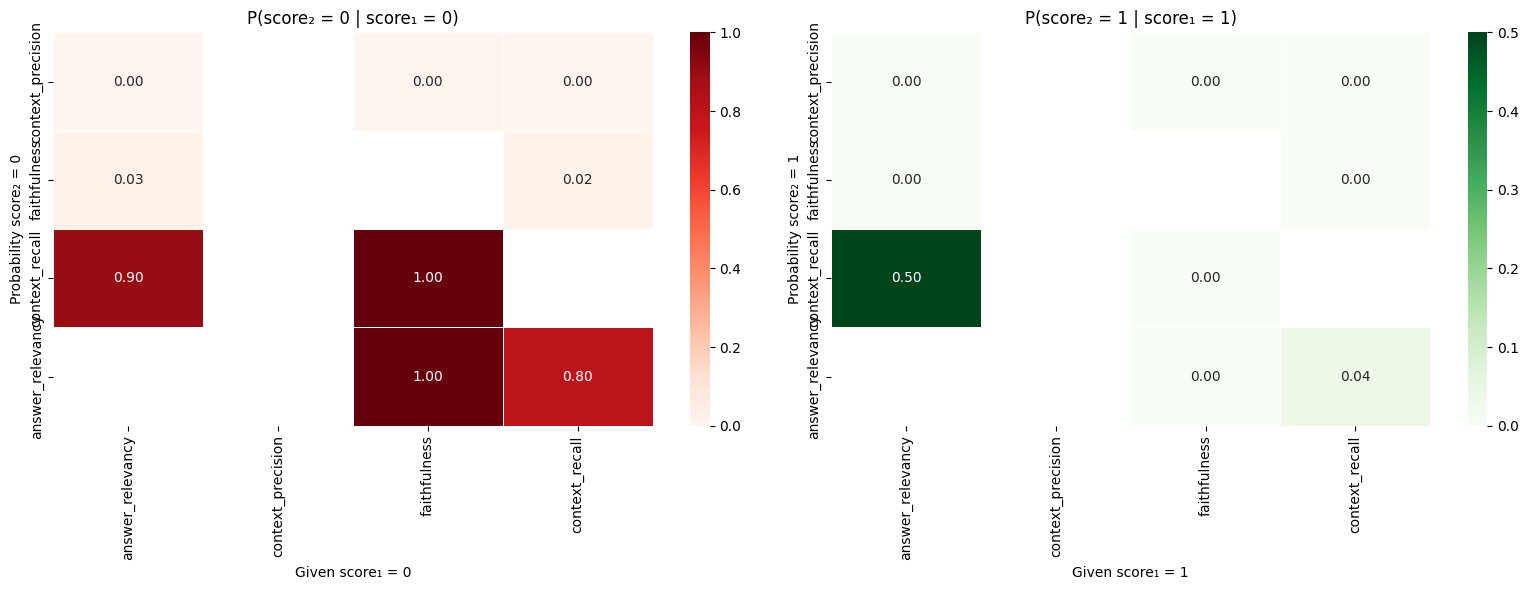

In [49]:
plot_score_outlier_relation(df_merged_400_300_D_D)

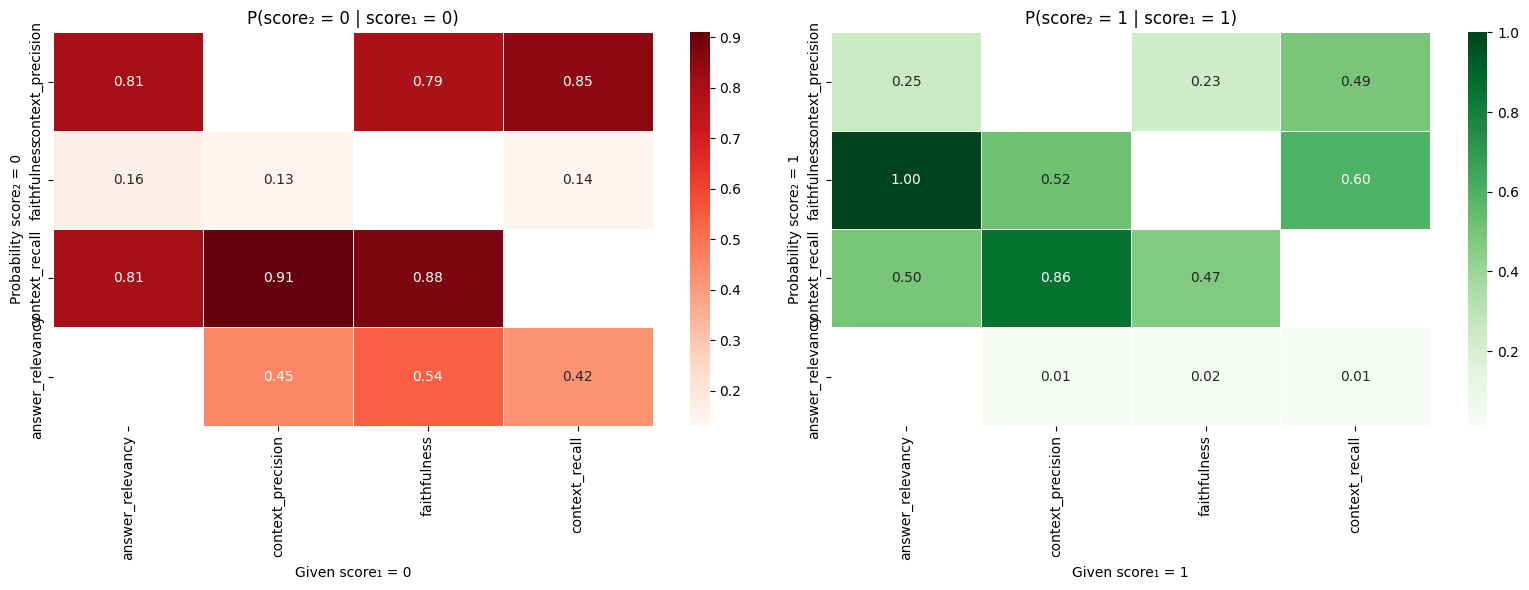

In [51]:
plot_score_outlier_relation(df_merged_400_300_O_O)

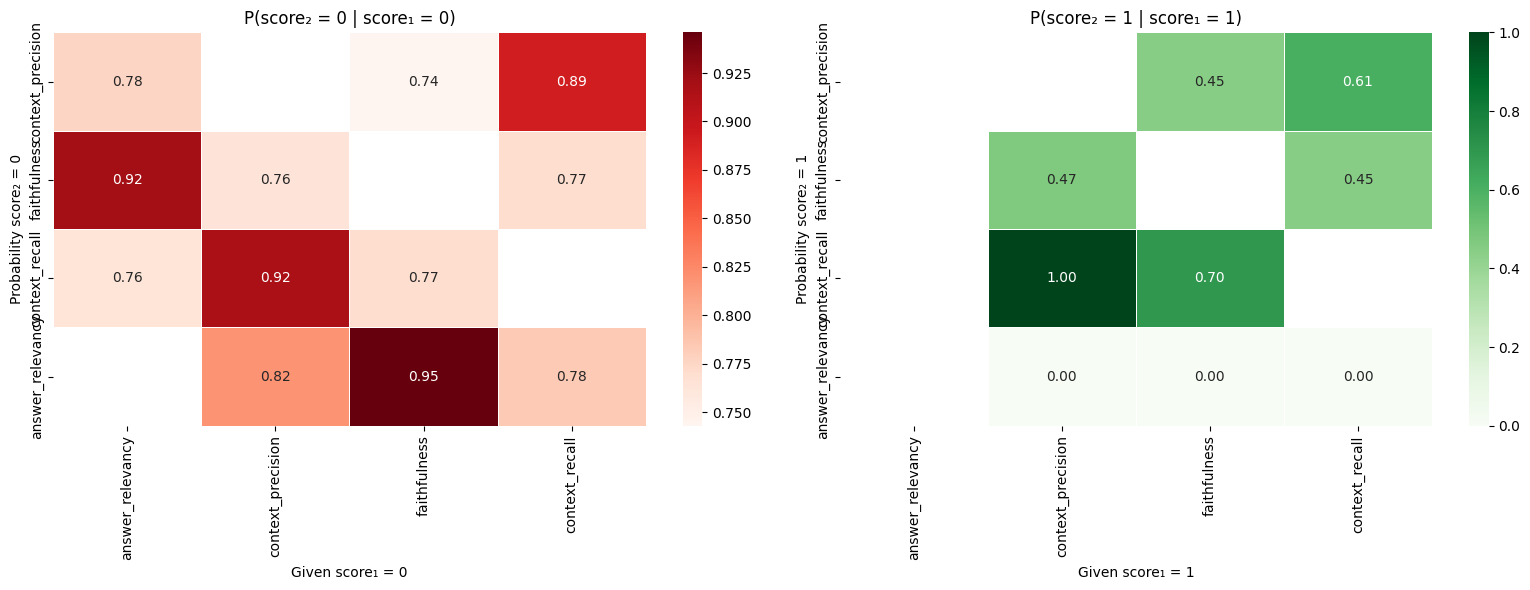

In [53]:
plot_score_outlier_relation(df_merged_400_150_O_O)

In [44]:
df_merged_100_100_D_D_1 = merge_questions_and_scores(*get_rating_data(4, host="http://localhost:9877"))
df_merged_100_100_D_D_2 = merge_questions_and_scores(*get_rating_data(5, host="http://localhost:9877"))
df_merged_100_100_D_D_3 = merge_questions_and_scores(*get_rating_data(6, host="http://localhost:9877"))
df_merged_100_100_D_D_4 = merge_questions_and_scores(*get_rating_data(7, host="http://localhost:9877"))

In [77]:
df_merged_100_100_O_O_1 = merge_questions_and_scores(*get_rating_data(78))
df_merged_100_100_O_O_2 = merge_questions_and_scores(*get_rating_data(79))
df_merged_100_100_O_O_3 = merge_questions_and_scores(*get_rating_data(80))
df_merged_100_100_O_O_4 = merge_questions_and_scores(*get_rating_data(127))
df_merged_100_100_O_O_5 = merge_questions_and_scores(*get_rating_data(136))

#fig = plot_score_distributions(df_merged_100_100_O_O_3)

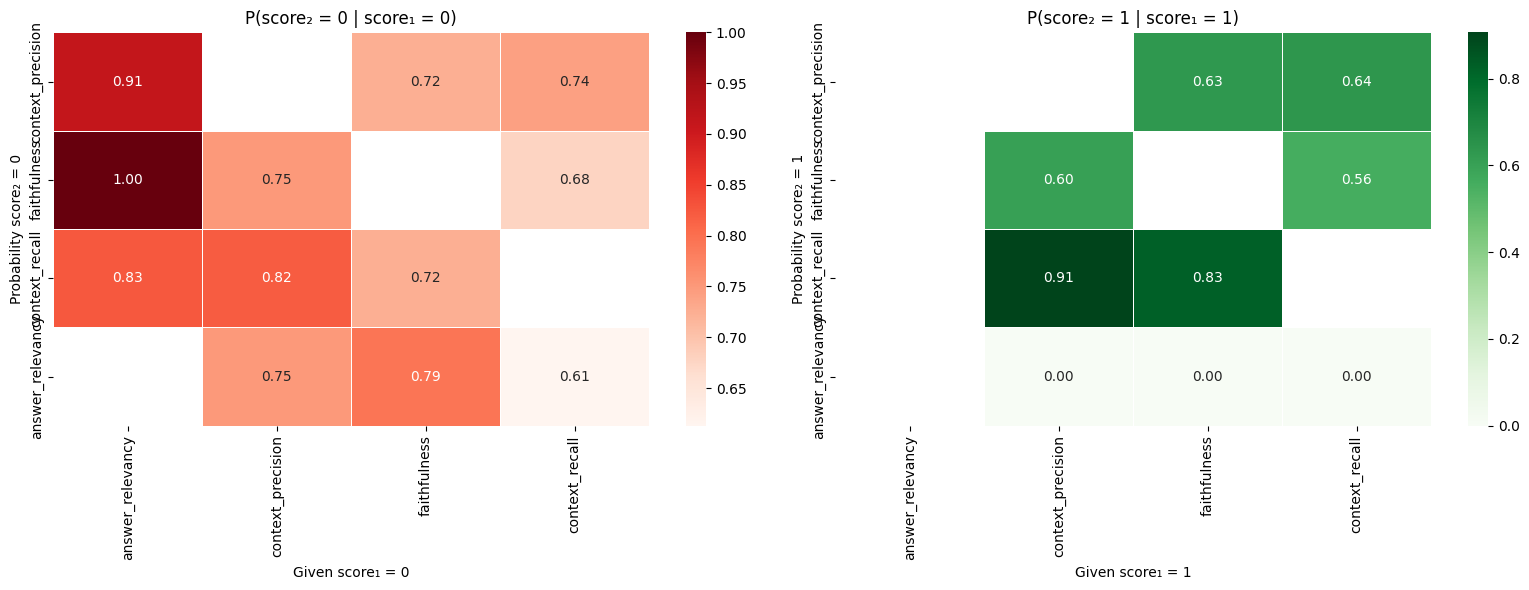

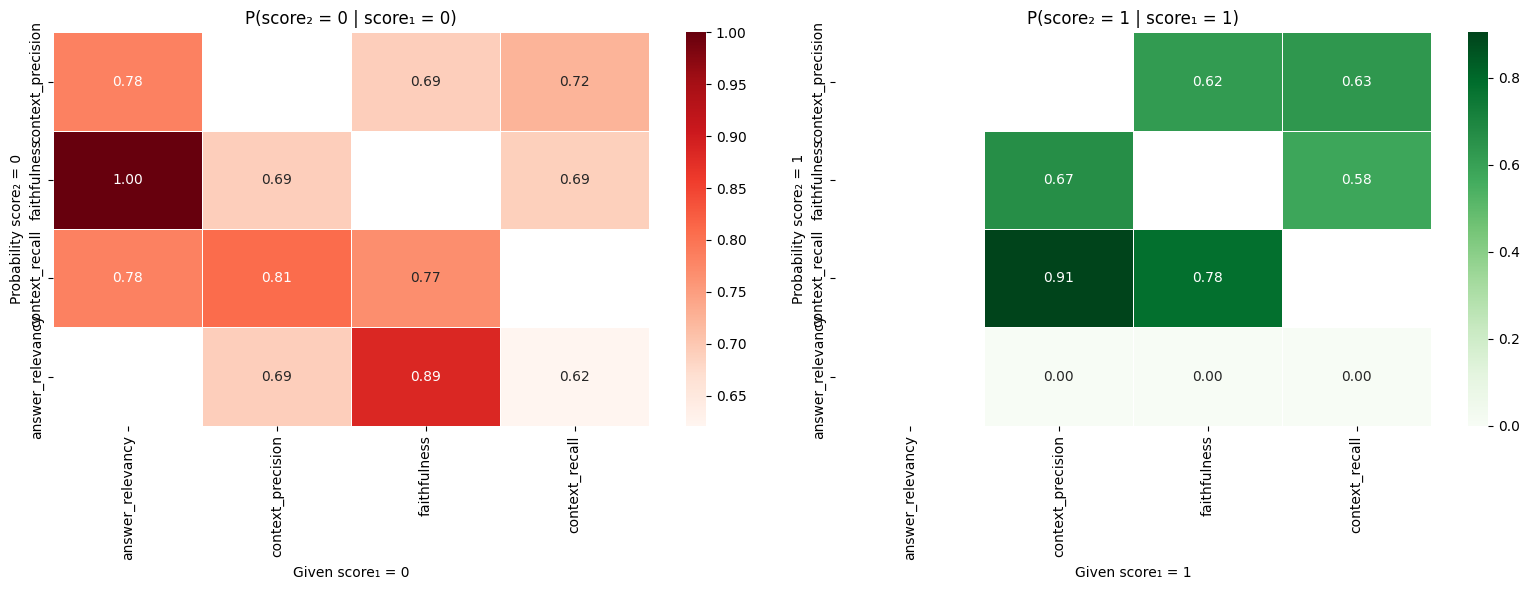

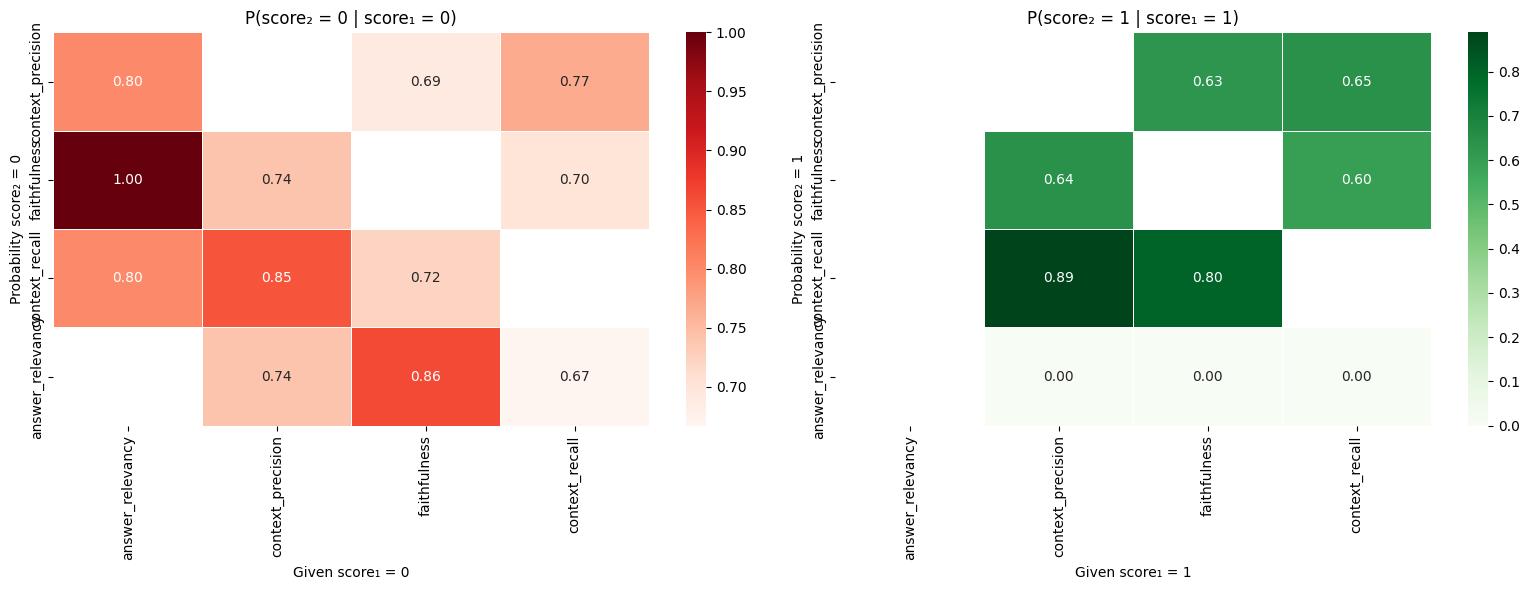

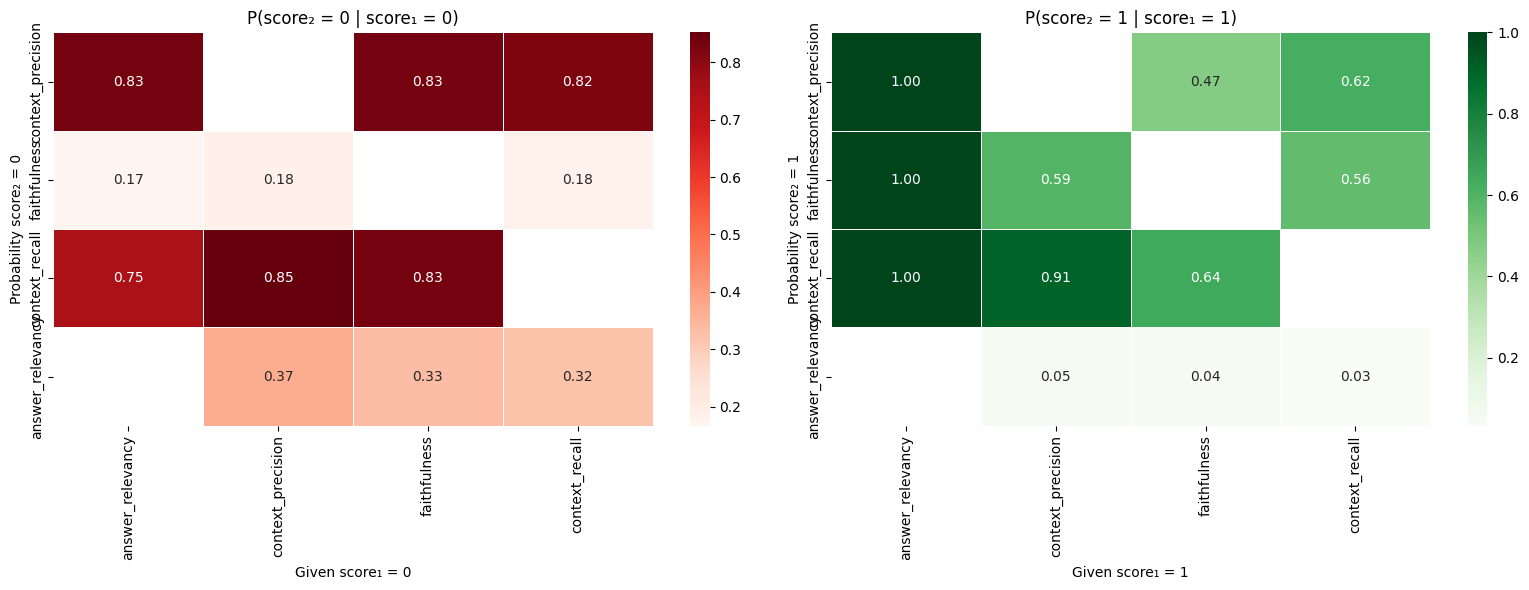

In [75]:
plot_score_outlier_relation(df_merged_100_100_O_O_1)
plot_score_outlier_relation(df_merged_100_100_O_O_2)
plot_score_outlier_relation(df_merged_100_100_O_O_3)
plot_score_outlier_relation(df_merged_100_100_O_O_4)

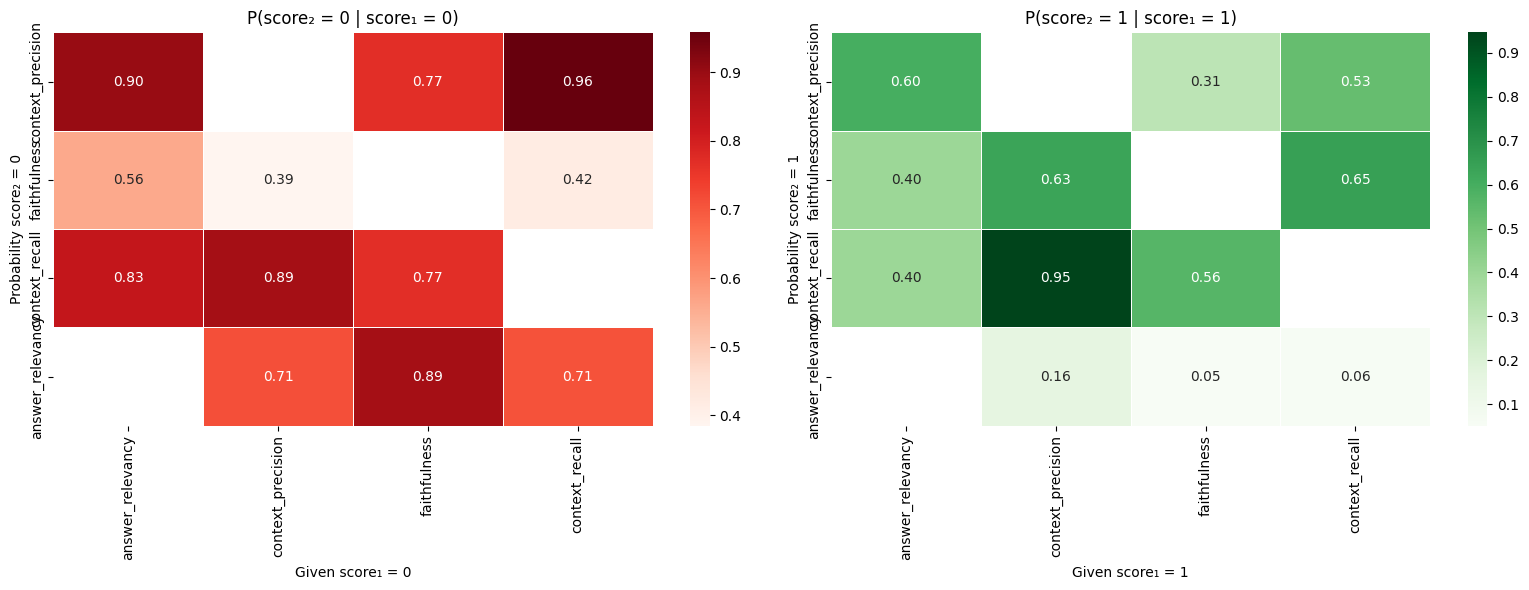

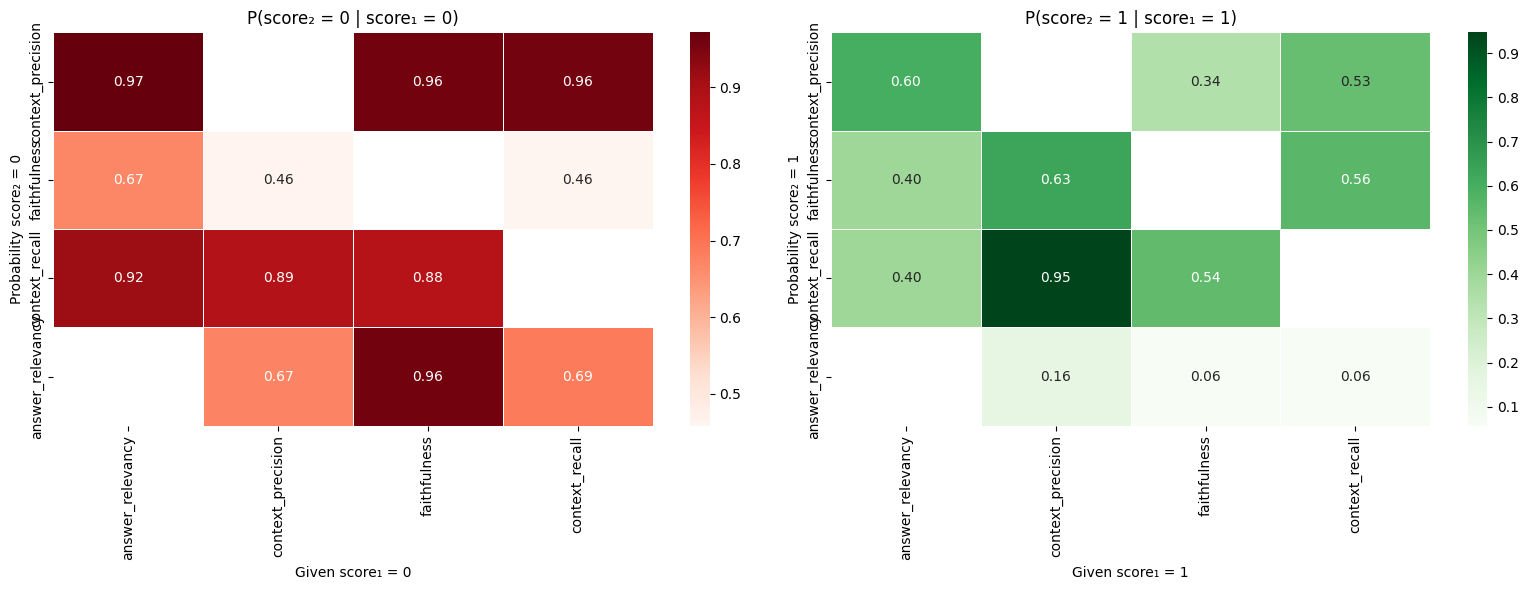

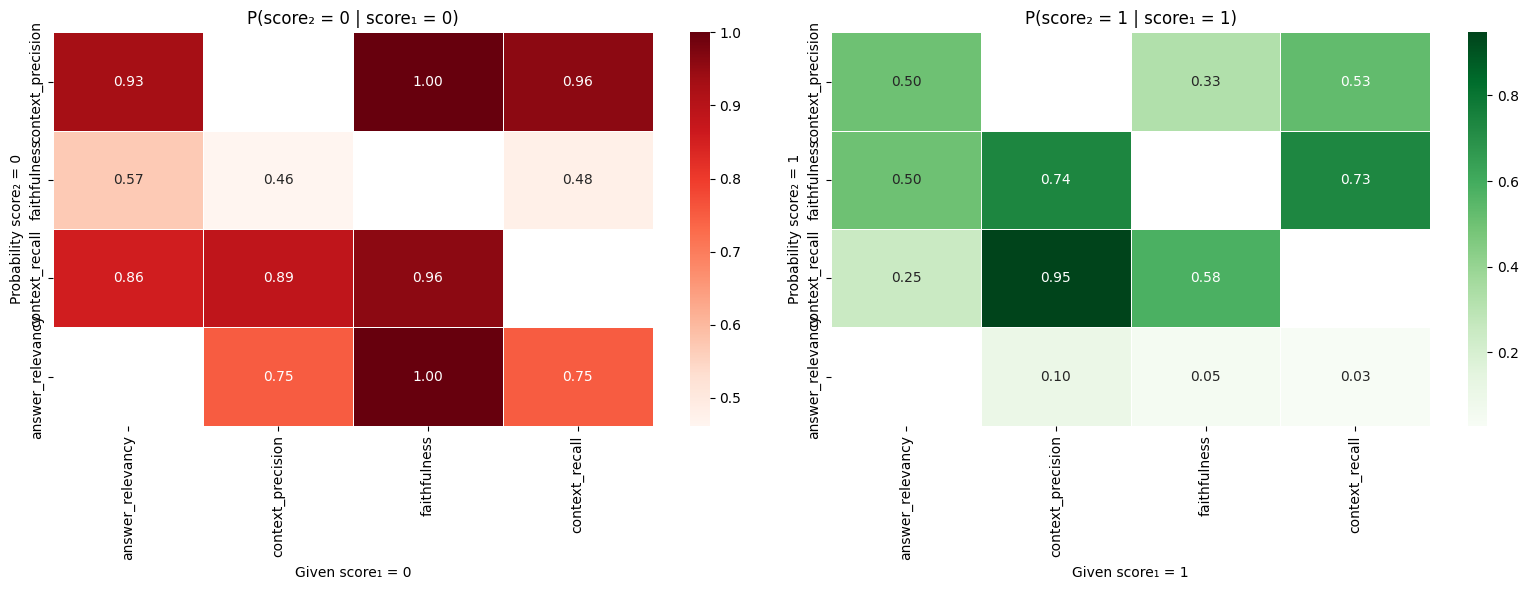

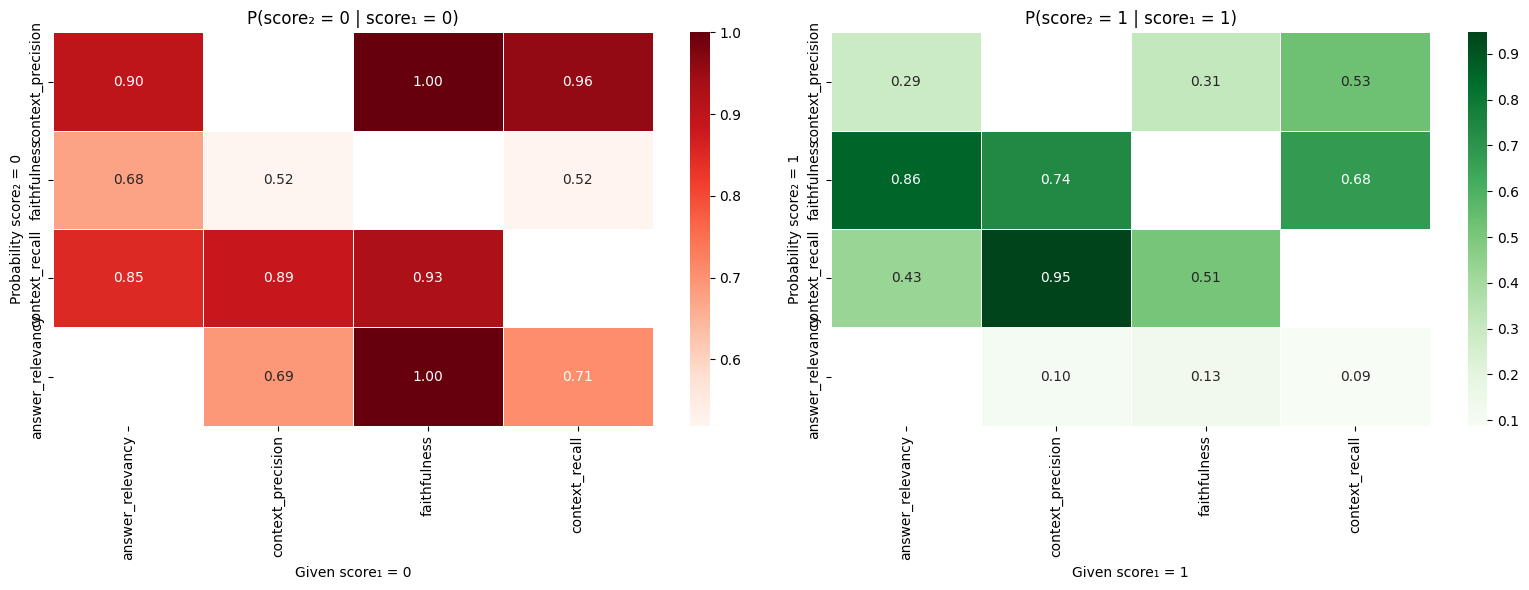

In [76]:
plot_score_outlier_relation(df_merged_100_100_D_D_1)
plot_score_outlier_relation(df_merged_100_100_D_D_2)
plot_score_outlier_relation(df_merged_100_100_D_D_3)
plot_score_outlier_relation(df_merged_100_100_D_D_4)

In [78]:
df_merged_100_100_O_O_1_scores = df_merged_100_100_O_O_1[['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']]
df_merged_100_100_O_O_2_scores = df_merged_100_100_O_O_2[['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']]
df_merged_100_100_O_O_3_scores = df_merged_100_100_O_O_3[['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']]
df_merged_100_100_O_O_4_scores = df_merged_100_100_O_O_4[['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']]
df_merged_100_100_O_O_5_scores = df_merged_100_100_O_O_5[['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']]

df_merged_100_100_O_O_1_scores["run"] = "Run 1"
df_merged_100_100_O_O_2_scores["run"] = "Run 2"
df_merged_100_100_O_O_3_scores["run"] = "Run 3"
df_merged_100_100_O_O_4_scores["run"] = "Run 4"
df_merged_100_100_O_O_5_scores["run"] = "Run 5"

df_all_100_100_O_O = pd.concat([df_merged_100_100_O_O_1_scores, df_merged_100_100_O_O_2_scores, df_merged_100_100_O_O_3_scores, df_merged_100_100_O_O_4_scores, df_merged_100_100_O_O_5_scores], ignore_index=True)

# Melt for seaborn
score_columns = ['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']
df_melted_100_100_O_O = df_all_100_100_O_O.melt(id_vars="run", value_vars=score_columns, var_name="metric", value_name="score")

/var/folders/xt/mj52lxfd1fd9j29gs0q1pdjc0000gn/T/ipykernel_9278/162520423.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_100_100_O_O_1_scores["run"] = "Run 1"
/var/folders/xt/mj52lxfd1fd9j29gs0q1pdjc0000gn/T/ipykernel_9278/162520423.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_100_100_O_O_2_scores["run"] = "Run 2"
/var/folders/xt/mj52lxfd1fd9j29gs0q1pdjc0000gn/T/ipykernel_9278/162520423.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [53]:
df_merged_100_100_D_D_1_scores = df_merged_100_100_D_D_1[['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']]
df_merged_100_100_D_D_2_scores = df_merged_100_100_D_D_2[['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']]
df_merged_100_100_D_D_3_scores = df_merged_100_100_D_D_3[['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']]
df_merged_100_100_D_D_4_scores = df_merged_100_100_D_D_4[['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']]

df_merged_100_100_D_D_1_scores["run"] = "Run 1"
df_merged_100_100_D_D_2_scores["run"] = "Run 2"
df_merged_100_100_D_D_3_scores["run"] = "Run 3"
df_merged_100_100_D_D_4_scores["run"] = "Run 4"

df_all_100_100_D_D = pd.concat([df_merged_100_100_D_D_1_scores, df_merged_100_100_D_D_2_scores, df_merged_100_100_D_D_3_scores, df_merged_100_100_D_D_4_scores], ignore_index=True)

# Melt for seaborn
score_columns = ['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']
df_melted_100_100_D_D = df_all_100_100_D_D.melt(id_vars="run", value_vars=score_columns, var_name="metric", value_name="score")

/var/folders/xt/mj52lxfd1fd9j29gs0q1pdjc0000gn/T/ipykernel_9278/2869350649.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_100_100_D_D_1_scores["run"] = "Run 1"
/var/folders/xt/mj52lxfd1fd9j29gs0q1pdjc0000gn/T/ipykernel_9278/2869350649.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged_100_100_D_D_2_scores["run"] = "Run 2"
/var/folders/xt/mj52lxfd1fd9j29gs0q1pdjc0000gn/T/ipykernel_9278/2869350649.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [60]:
# Create boxplot
def create_boxplot(df_melted):
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df_melted, x="metric", y="score", hue="run", split=True)
    plt.title("Score Distribution per Run")
    plt.ylabel("Score")
    plt.xlabel("Metric")
    plt.ylim(0, 1.05)
    plt.legend(title="Run")
    plt.tight_layout()
    plt.show()

    #summary = df_all.groupby("run")[score_columns].agg(["mean", "std"]).round(3)
    #print(summary)

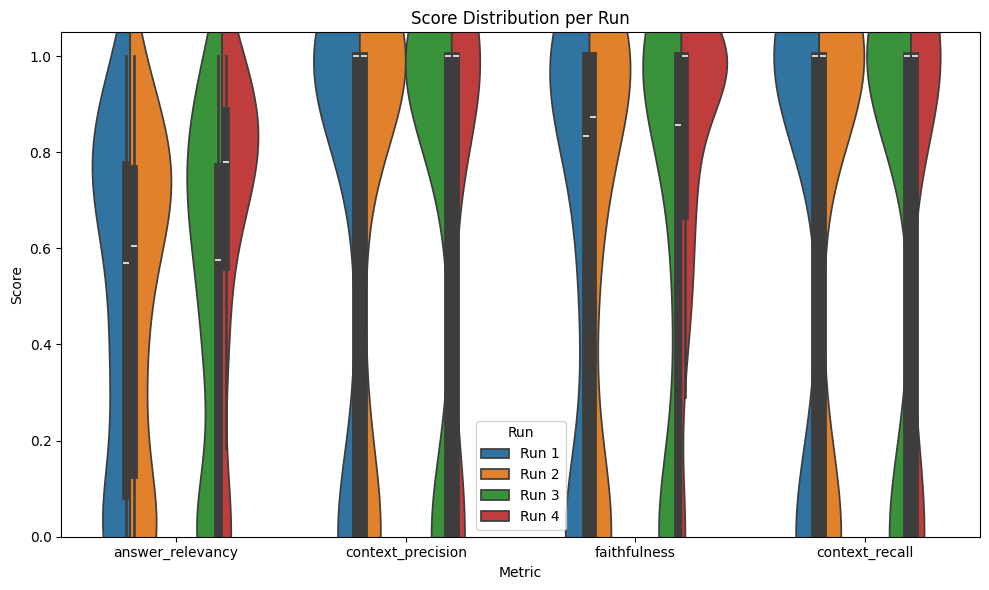

In [61]:
create_boxplot(df_melted_100_100_O_O)

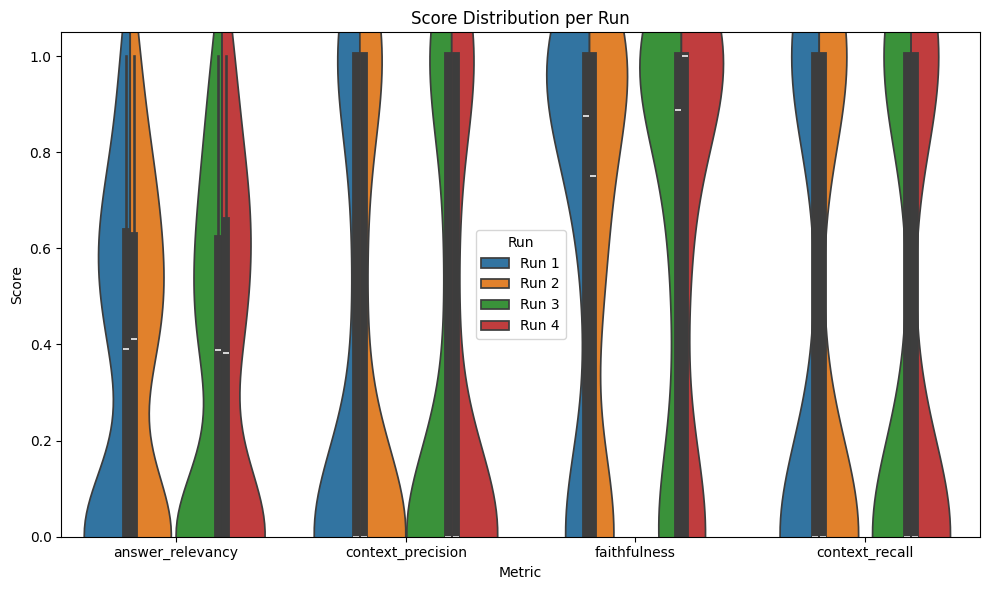

In [54]:
create_boxplot(df_melted_100_100_D_D)

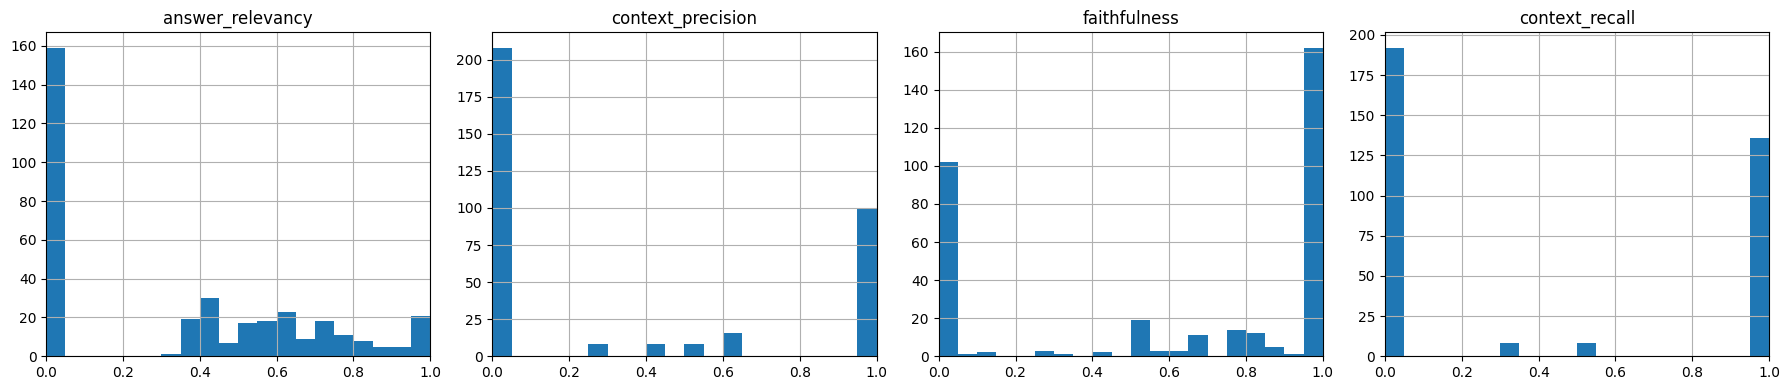

In [68]:
import matplotlib.pyplot as plt

score_columns = ['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']

fig, axes = plt.subplots(1, 4, figsize=(18, 4))

for i, col in enumerate(score_columns):
    df_all_100_100_D_D[col].hist(ax=axes[i], bins=20, range=(0, 1))
    axes[i].set_title(col)
    axes[i].set_xlim(0, 1)

plt.tight_layout()
plt.show()

/Users/leonbartz/.pyenv/versions/rag-eval-bachelor/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 9.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/leonbartz/.pyenv/versions/rag-eval-bachelor/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 57.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/leonbartz/.pyenv/versions/rag-eval-bachelor/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 46.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/leonbartz/.pyenv/versions/rag-eval-bachelor/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 65.8% of the points cannot be placed; you may want to decrease the size of the markers or use st

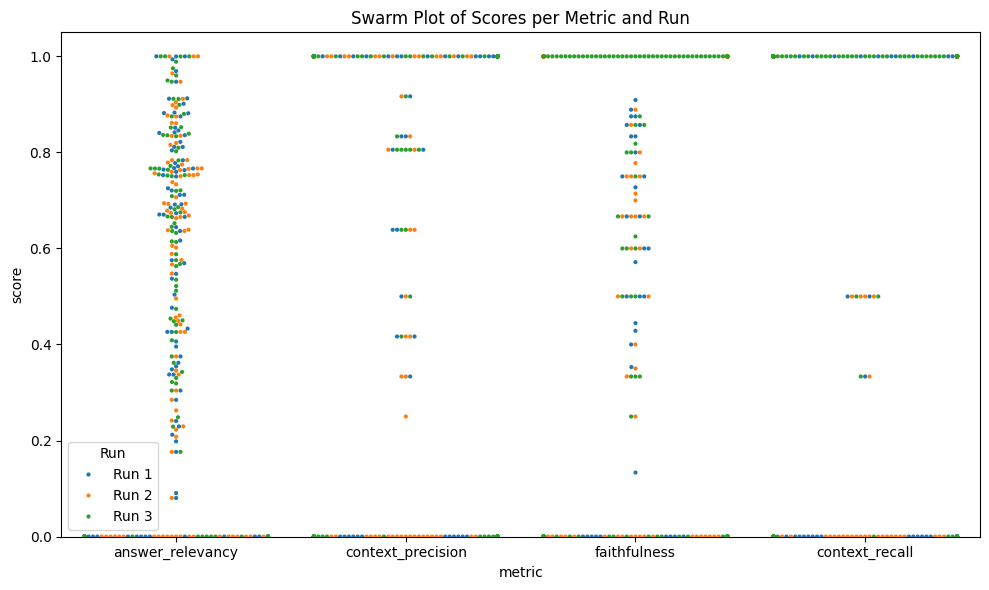

/Users/leonbartz/.pyenv/versions/rag-eval-bachelor/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 33.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/leonbartz/.pyenv/versions/rag-eval-bachelor/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 63.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/leonbartz/.pyenv/versions/rag-eval-bachelor/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 52.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/leonbartz/.pyenv/versions/rag-eval-bachelor/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 70.3% of the points cannot be placed; you may want to decrease the size of the markers or use s

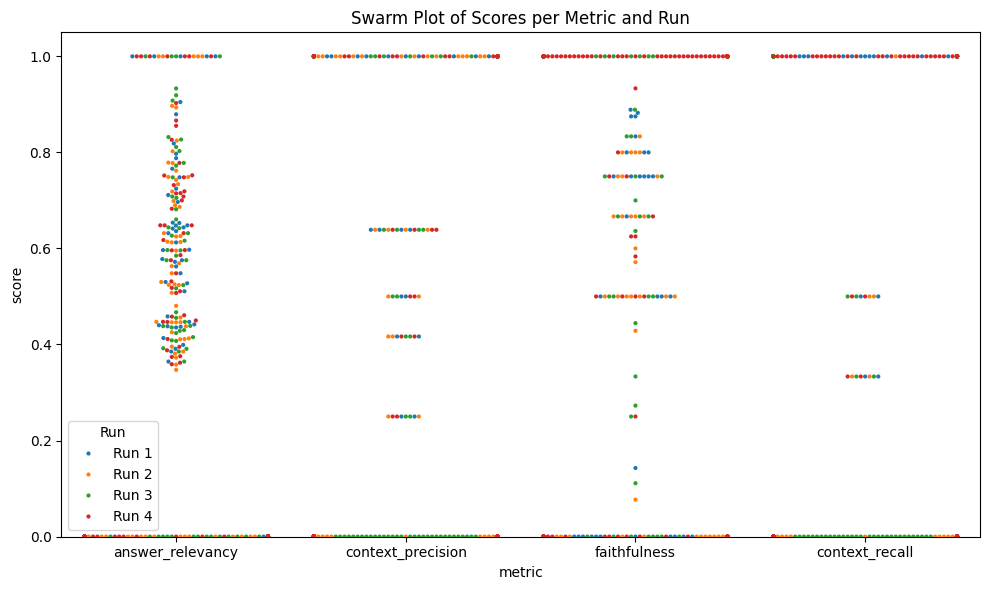

In [100]:
def create_swarmplot(df_melted):
    plt.figure(figsize=(10, 6))
    sns.swarmplot(data=df_melted, x="metric", y="score", hue="run", size=3)
    plt.title("Swarm Plot of Scores per Metric and Run")
    plt.ylim(0, 1.05)
    plt.legend(title="Run")
    plt.tight_layout()
    plt.show()

create_swarmplot(df_melted_100_100_O_O)
create_swarmplot(df_melted_100_100_D_D)

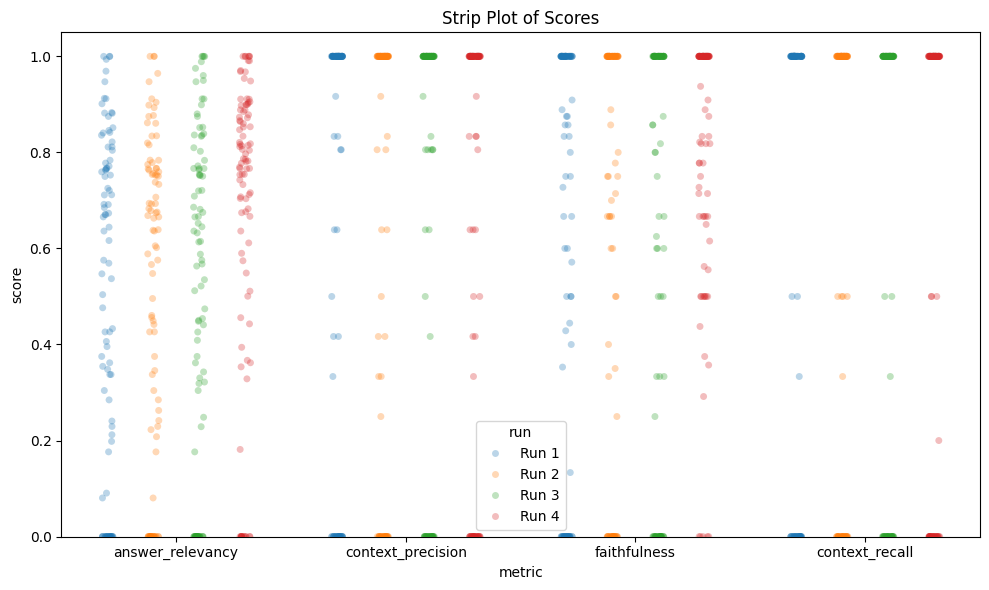

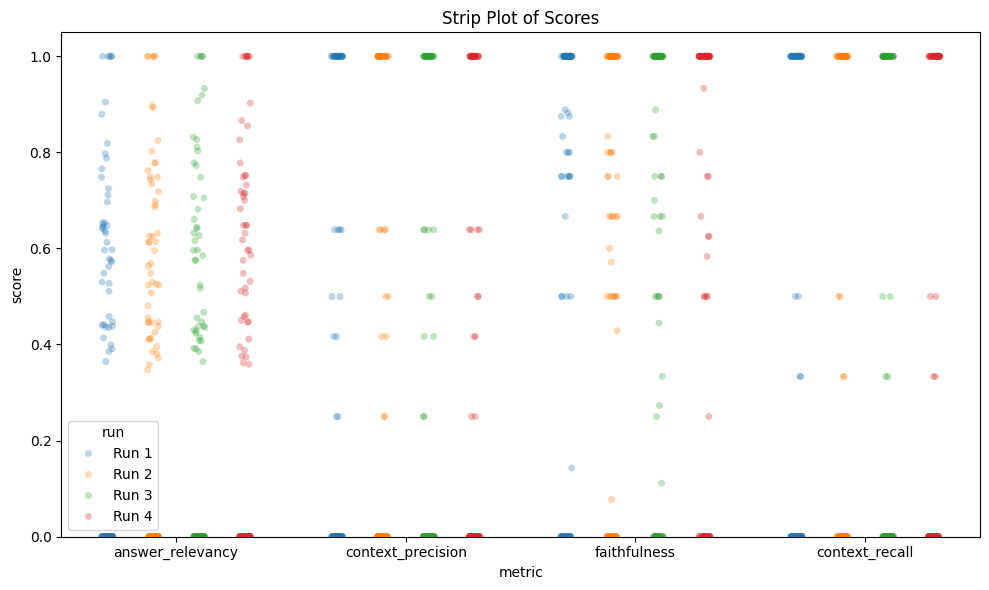

In [62]:
def create_stripplot(df_melted):
    plt.figure(figsize=(10, 6))
    sns.stripplot(data=df_melted, x="metric", y="score", hue="run", dodge=True, jitter=True, alpha=0.3)
    plt.title("Strip Plot of Scores")
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

create_stripplot(df_melted_100_100_O_O)
create_stripplot(df_melted_100_100_D_D)

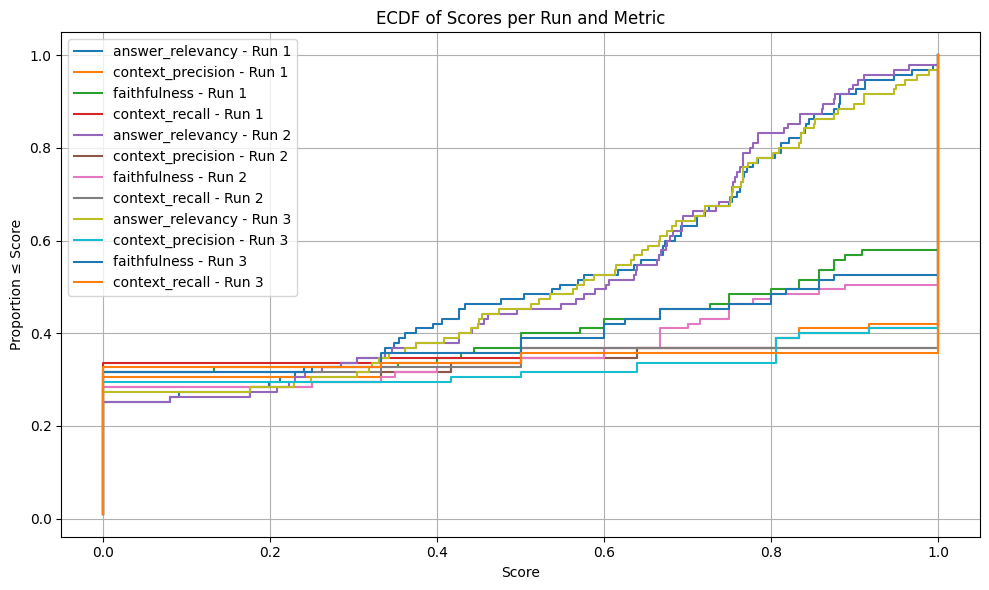

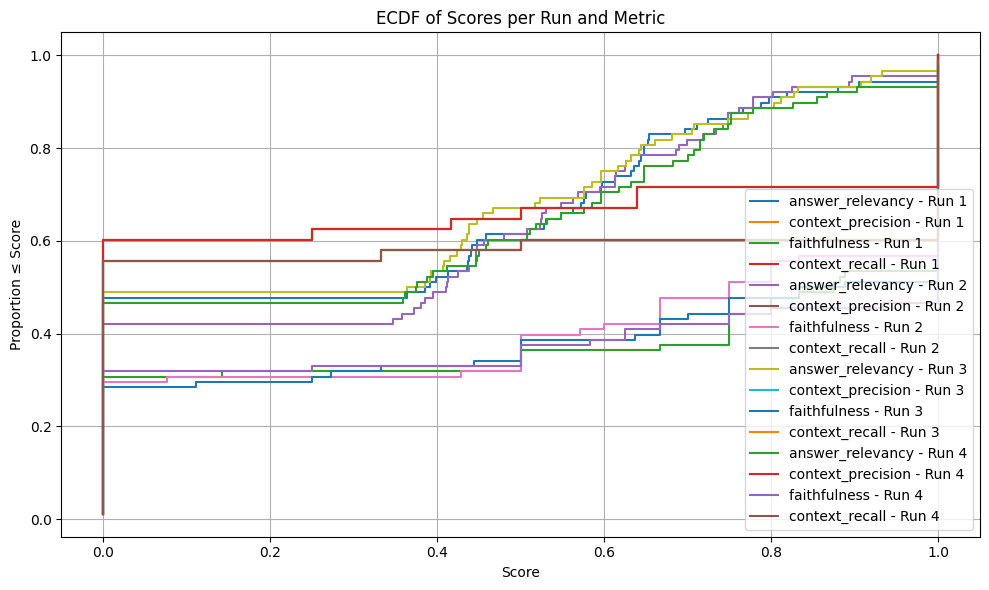

In [102]:
import statsmodels.api as sm

def create_ecdf(df_melted):
    plt.figure(figsize=(10, 6))
    for run in df_melted['run'].unique():
        for metric in ['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']:
            values = df_melted[(df_melted['run'] == run) & (df_melted['metric'] == metric)]['score']
            x = np.sort(values)
            y = np.arange(1, len(x) + 1) / len(x)
            plt.step(x, y, label=f"{metric} - {run}")

    plt.legend()
    plt.title("ECDF of Scores per Run and Metric")
    plt.xlabel("Score")
    plt.ylabel("Proportion ≤ Score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

create_ecdf(df_melted_100_100_O_O)
create_ecdf(df_melted_100_100_D_D)

In [70]:
summary_stats_D_D = df_melted_100_100_D_D.groupby(['run', 'metric'])['score'].agg(['mean', 'std']).reset_index()

# Optional: pivot to compare runs side-by-side per metric
summary_pivot_D_D = summary_stats_D_D.pivot(index='metric', columns='run')

# Clean up the column names
summary_pivot_D_D.columns = [f"{stat}_{run}" for stat, run in summary_pivot_D_D.columns]

# Display result
print(summary_pivot_D_D)

                   mean_Run 1  mean_Run 2  mean_Run 3  mean_Run 4  std_Run 1  \
metric                                                                         
answer_relevancy     0.336237    0.365612    0.328918    0.358452   0.346440   
context_precision    0.343550    0.343550    0.343550    0.343550   0.448986   
context_recall       0.414729    0.414729    0.414729    0.414729   0.484224   
faithfulness         0.624284    0.592781    0.627052    0.623333   0.442223   

                   std_Run 2  std_Run 3  std_Run 4  
metric                                              
answer_relevancy    0.339773   0.346658   0.361005  
context_precision   0.448986   0.448986   0.448986  
context_recall      0.484224   0.484224   0.484224  
faithfulness        0.428975   0.435953   0.453010  


In [79]:
summary_stats_O_O = df_melted_100_100_O_O.groupby(['run', 'metric'])['score'].agg(['mean', 'std']).reset_index()

# Optional: pivot to compare runs side-by-side per metric
summary_pivot_O_O = summary_stats_O_O.pivot(index='metric', columns='run')

# Clean up the column names
summary_pivot_O_O.columns = [f"{stat}_{run}" for stat, run in summary_pivot_O_O.columns]

# Display result
print(summary_pivot_O_O)

                   mean_Run 1  mean_Run 2  mean_Run 3  mean_Run 4  mean_Run 5  \
metric                                                                          
answer_relevancy     0.484397    0.490477    0.493449    0.666498    0.680692   
context_precision    0.664620    0.669031    0.683918    0.666374    0.669591   
context_recall       0.656140    0.663121    0.666667    0.681053    0.670526   
faithfulness         0.603371    0.632479    0.613324    0.815478    0.800457   

                   std_Run 1  std_Run 2  std_Run 3  std_Run 4  std_Run 5  
metric                                                                    
answer_relevancy    0.348227   0.340369   0.350795   0.315288   0.313960  
context_precision   0.450630   0.445482   0.444632   0.444472   0.444693  
context_recall      0.469401   0.461142   0.465729   0.458094   0.456367  
faithfulness        0.438610   0.433597   0.443828   0.273422   0.295350  


# ANALYSE QUESTION TYPE INFLUENCE AND TOPIC

In [64]:
score_columns = ['answer_relevancy', 'context_precision', 'faithfulness', 'context_recall']
def plot_scores_by_group_combined(df, score_columns, group_column, max_cols=2):
    """
    Plot violin plots of given score columns, grouped by values in group_column.
    Combine multiple group plots into subplots to reduce size.

    Parameters:
    - df: DataFrame with score columns and a group column (e.g., 'metadata.topic')
    - score_columns: list of score column names
    - group_column: string, column name to group by
    - max_cols: int, number of columns per row in the combined plot
    """
    import math

    # Ensure group_column is accessible (flatten nested dicts if needed)
    if group_column.startswith("metadata."):
        metadata_key = group_column.split(".")[1]
        df[group_column] = df["metadata"].apply(
            lambda meta: meta.get(metadata_key, "Unknown") if isinstance(meta, dict) else "Unknown"
        )

    # Melt the DataFrame for seaborn
    df_melted = df.melt(id_vars=group_column, value_vars=score_columns,
                        var_name="metric", value_name="score")

    unique_groups = df[group_column].dropna().unique()
    num_groups = len(unique_groups)
    num_cols = min(max_cols, num_groups)
    num_rows = math.ceil(num_groups / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), squeeze=False)
    axes = axes.flatten()

    for idx, group in enumerate(unique_groups):
        ax = axes[idx]
        sns.violinplot(
            data=df_melted[df_melted[group_column] == group],
            x="metric", y="score", inner="box", ax=ax
        )
        ax.set_title(f"{group_column} = {group}")
        ax.set_ylim(0, 1.05)
        ax.set_xlabel("")
        ax.set_ylabel("Score")

    # Hide unused subplots
    for idx in range(len(unique_groups), len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

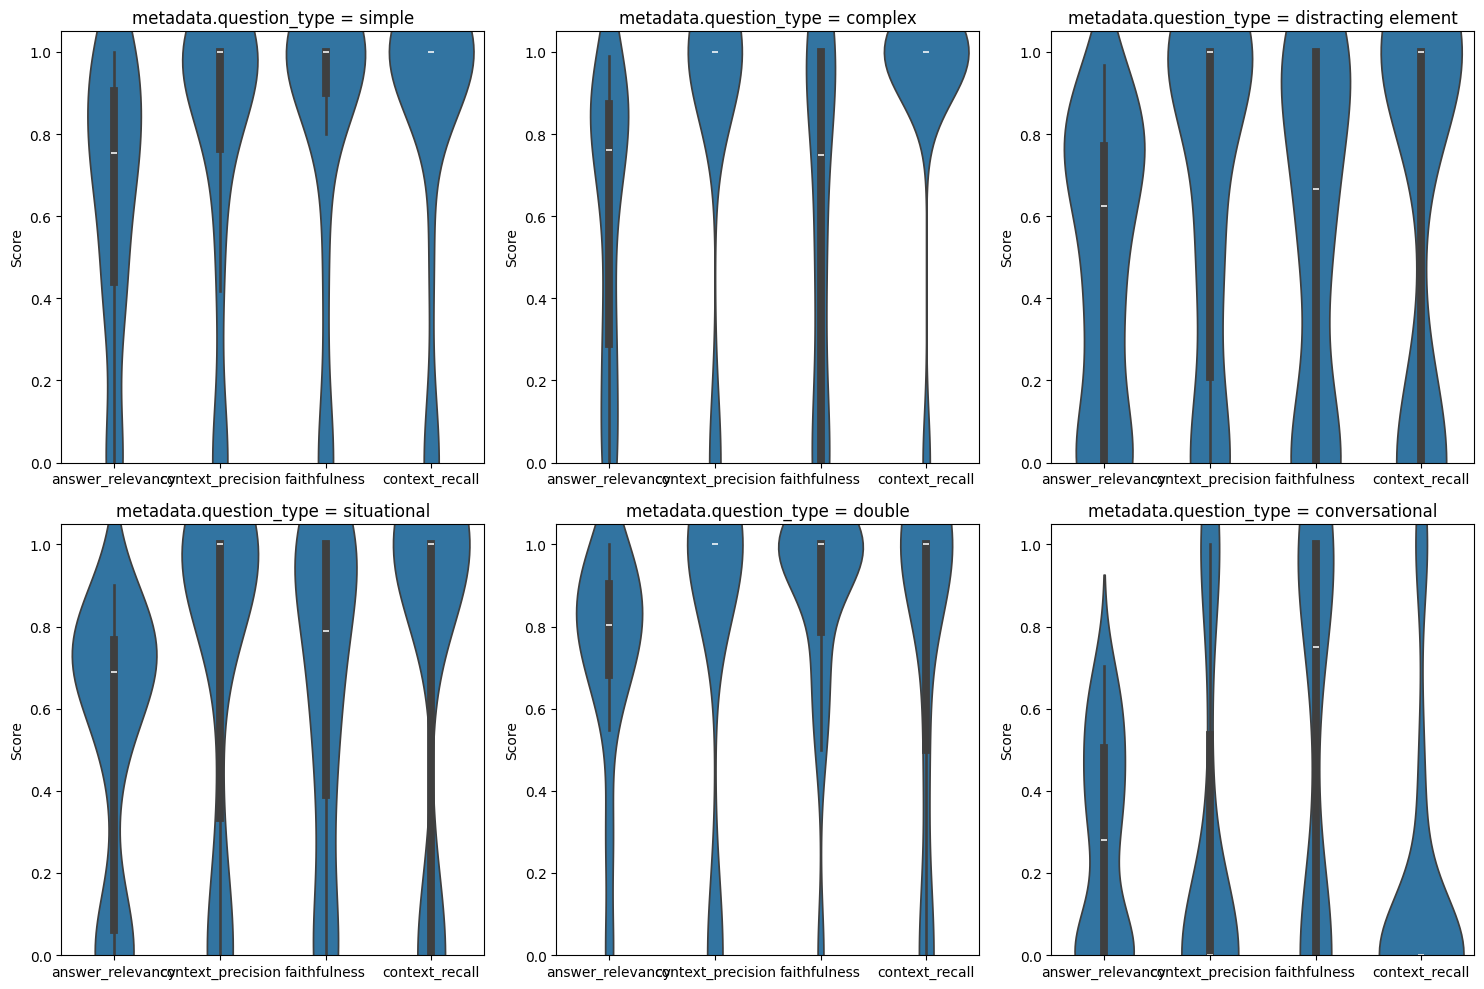

In [66]:
plot_scores_by_group_combined(pd.concat([df_merged_100_100_O_O_1, df_merged_100_100_O_O_2, df_merged_100_100_O_O_3, df_merged_100_100_O_O_4], ignore_index=True), score_columns, "metadata.question_type", max_cols=3)

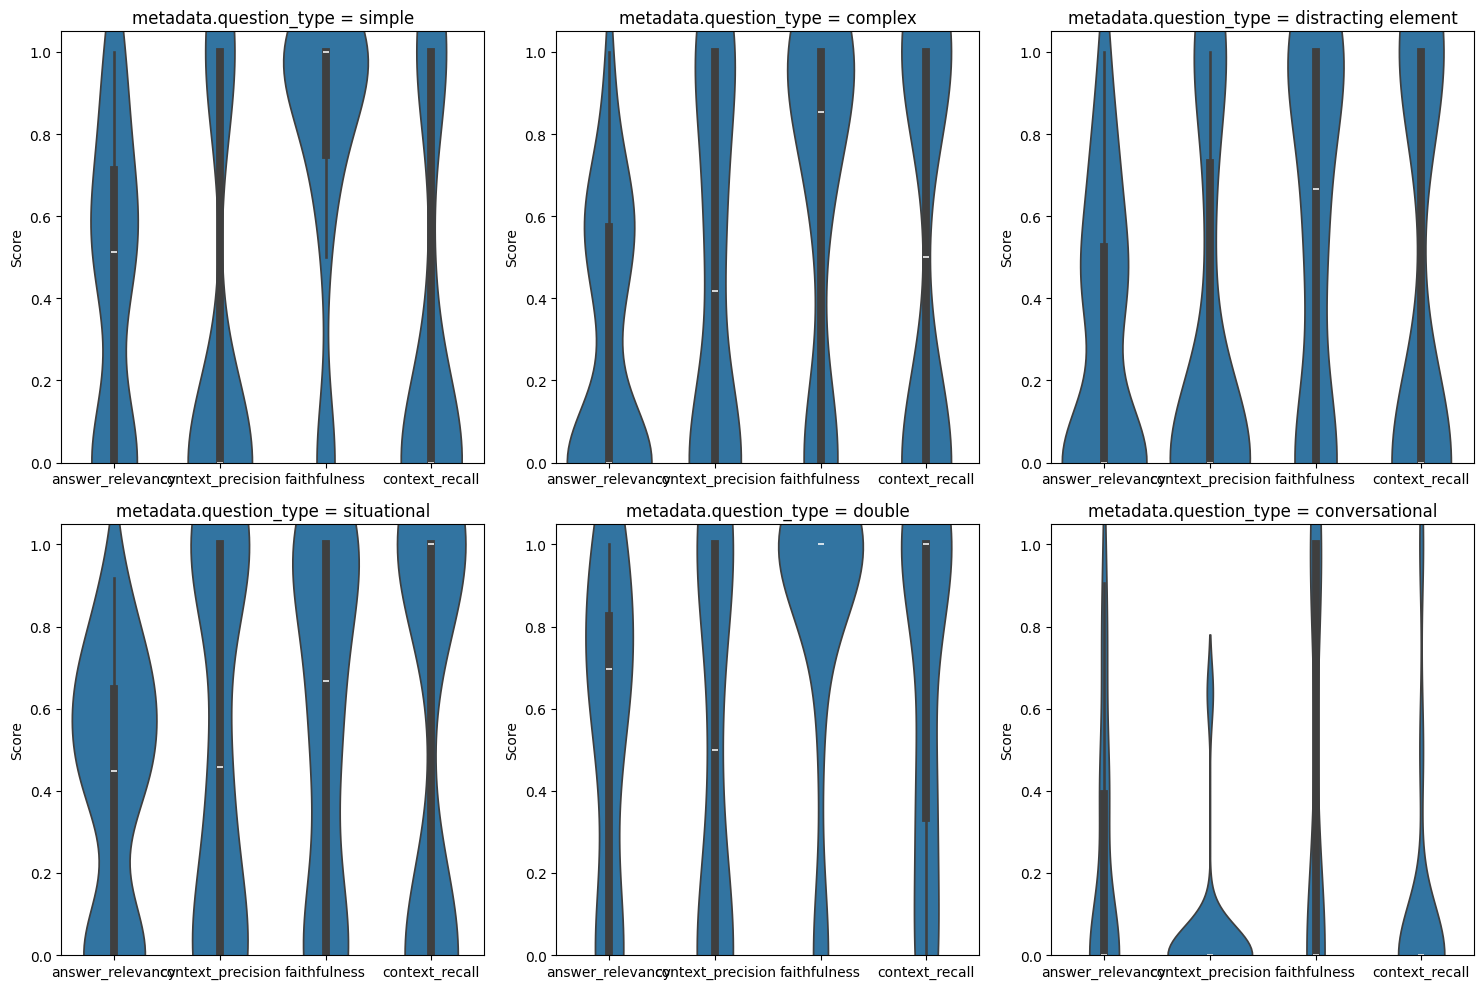

In [67]:
plot_scores_by_group_combined(pd.concat([df_merged_100_100_D_D_1, df_merged_100_100_D_D_2, df_merged_100_100_D_D_3, df_merged_100_100_D_D_4], ignore_index=True), score_columns, "metadata.question_type", max_cols=3)

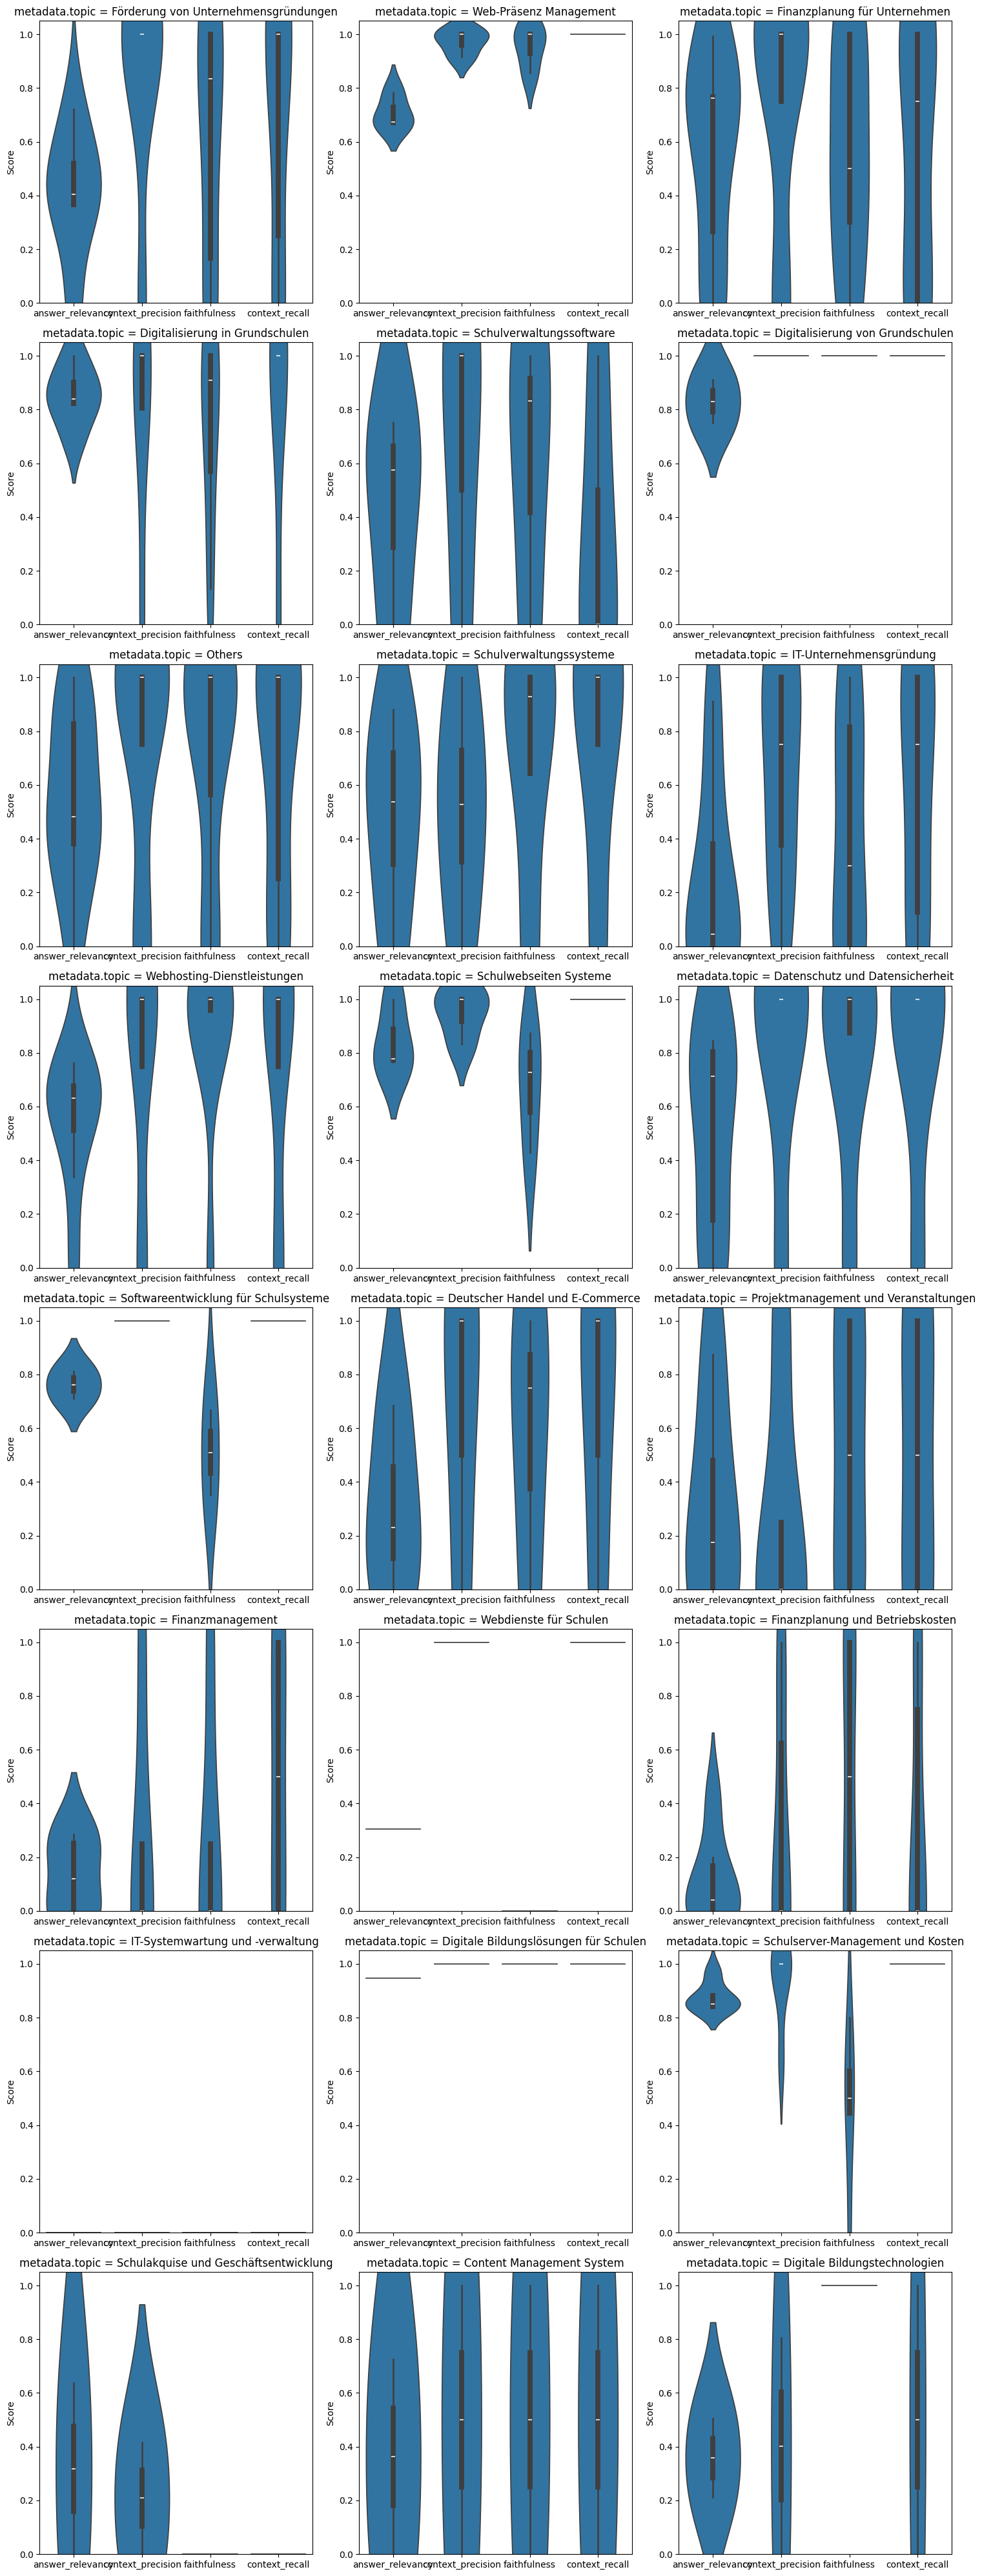

In [116]:
plot_scores_by_group_combined(df_merged_100_100_O_O_1, score_columns, "metadata.topic", max_cols=3)

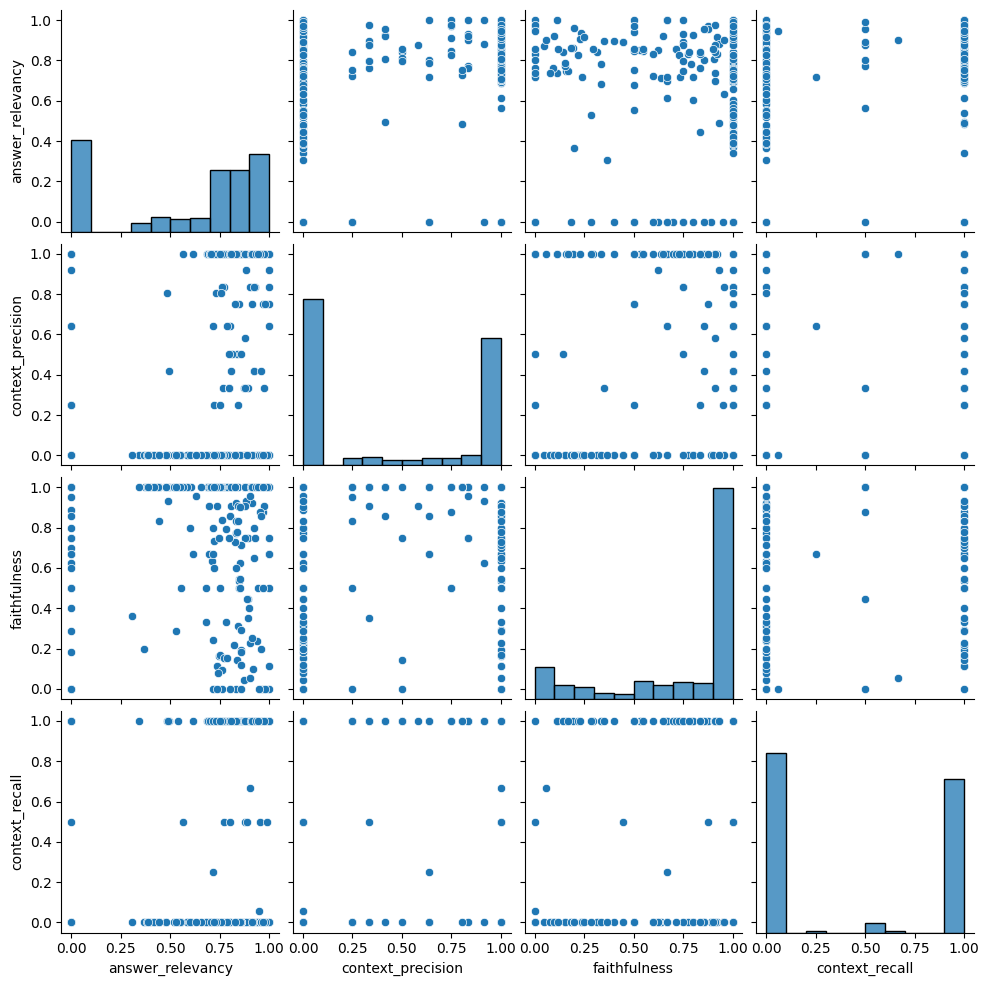

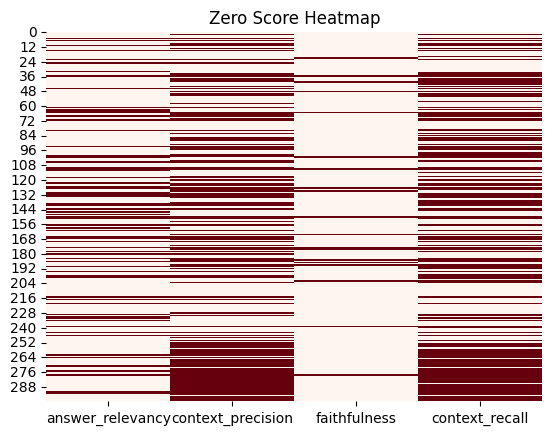

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot for relationships
sns.pairplot(scores_df)
plt.show()

# Heatmap of where values are 0
sns.heatmap((scores_df == 0).astype(int), cmap="Reds", cbar=False)
plt.title("Zero Score Heatmap")
plt.show()

In [118]:
# The scores to check
scores_to_check = [
    'answer_relevancy',
    'context_precision',
    'faithfulness',
    'context_recall'
]

# Find entries where all specified scores are 0.0
entries_with_all_zeros = df_merged_400_300[
    df_merged_400_300[scores_to_check].eq(0.0).all(axis=1)
]

# Print the number of matching entries found
print(f"Found {len(entries_with_all_zeros)} entries where all scores are 0.0.")

Found 12 entries where all scores are 0.0.


### Erwarteter Kontext

Wie auch schon bei der Betrachtung der Testsets fällt auf, dass das LLM die Frage so Formuliert als wäre der relevante Kontext gegeben und es daher erst garnicht möglich ist die relevanten Dokumente zu finde, etwas paradox

In [119]:
# If you want to examine these entries:
response_not_in = ["I don't know.", "Ich weiß nicht.", "I don't know", "Ich weiß es nicht.", "Ich weiß es nicht."]
if len(entries_with_all_zeros) > 0:
    print("\nEntries with all zero scores:")
    for idx, row in entries_with_all_zeros.iterrows():
        if row['response'] not in response_not_in:
            print("-"*500)
            print(f"\nEntry {idx}:")
            print(f"Question: {row['question']}")
            print(f"Answer: {row['response']}")
            print(f"Context: {row['reference_context']}")
            print(f"Context Erhalten: {row['retrieved_contexts']}")
            print("Scores:", {score: row[score] for score in scores_to_check})


Entries with all zero scores:
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Entry 111:
Question: Wie verhält sich das Ereignis, wenn es nicht gestoppt wird, keine spezielle Triggerfunktion definiert ist und im Kontext einer Anwendung eingesetzt wird, die eine eigene, von der Standard-Bubbling-Logik abweichende Ereignisverarbeitung implementiert?
Answer: Wenn das Ereignis nicht gestoppt wird, keine spezielle Triggerfunktion definiert ist und die Anwendung eine eigene, von der Standard-Bubbling-Logik abweichende Ereignisverarbeitung implem